[nltk_data] Downloading package stopwords to C:\Users\CYTech
[nltk_data]     Student\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Similarity matrix saved as 'theses_similarity.csv'


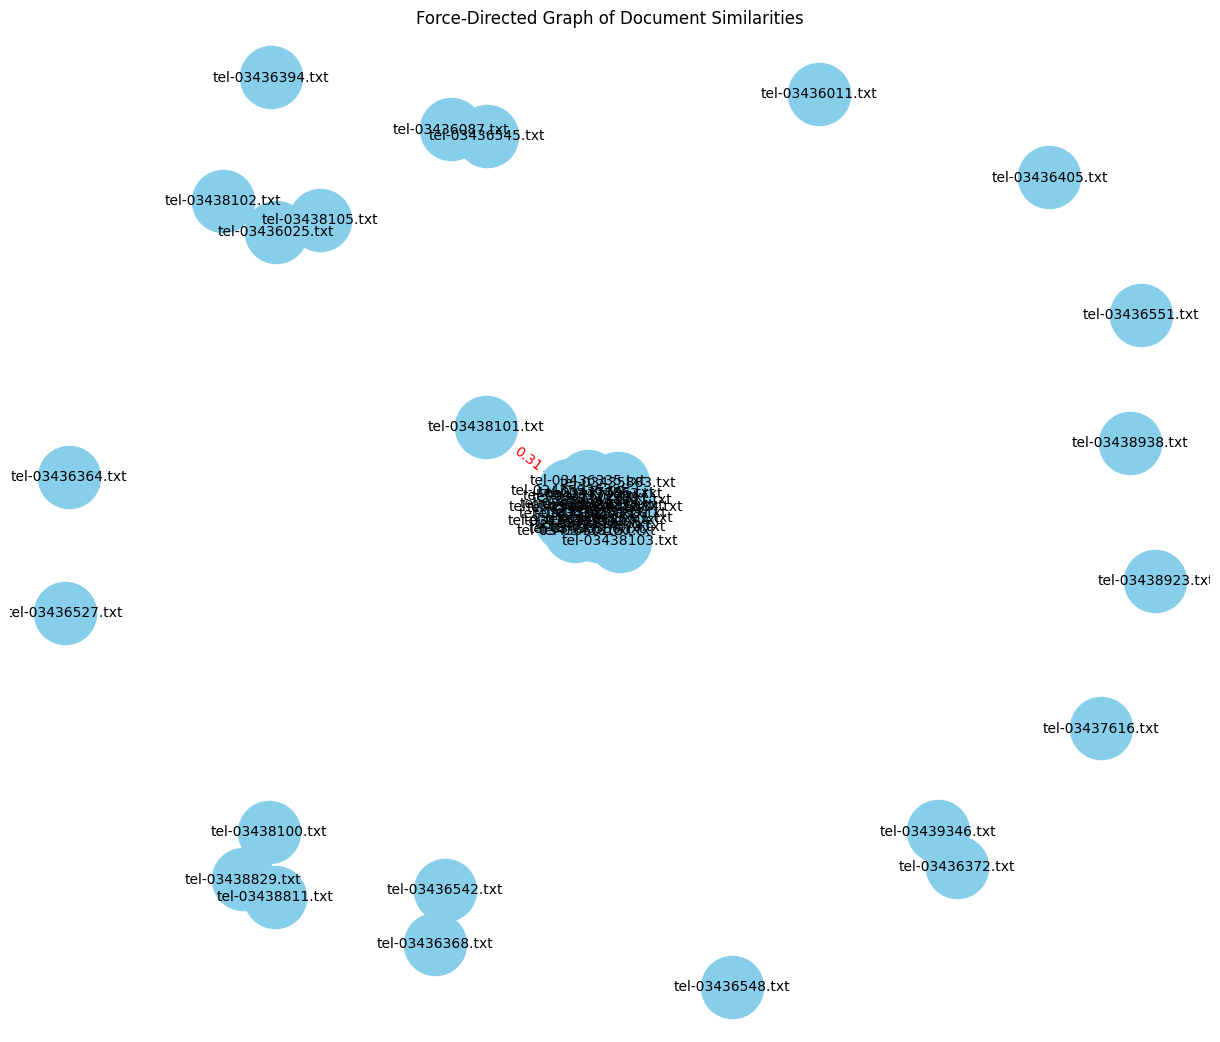

In [3]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from nltk.stem import SnowballStemmer

# Ensure necessary NLTK resources are downloaded
nltk.download('stopwords')

# 1. Load Text Files
def load_text_files(folder_path):
    file_data = []
    file_names = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            with open(os.path.join(folder_path, file_name), 'r', encoding='utf-8') as file:
                content = file.read().strip()
                if content:  # Exclude empty files
                    file_data.append(content)
                    file_names.append(file_name)
    return file_data, file_names

# 2. Preprocess Text using NLTK (French Stopwords and Stemming)
def preprocess_text(documents):
    # French stopwords
    stop_words = set(stopwords.words('french'))
    stemmer = SnowballStemmer('french')
    
    processed_docs = []
    for doc in documents:
        # Tokenize the text using a regex tokenizer for French
        tokens = regexp_tokenize(doc, pattern=r'\s|[\.,;?!\(\)"]', gaps=True)
        # Remove stopwords and stem
        filtered_tokens = [stemmer.stem(word) for word in tokens if word.lower() not in stop_words and word.isalpha()]
        processed_docs.append(" ".join(filtered_tokens))
    
    return processed_docs

# 3. TF-IDF Vectorization and Cosine Similarity
def compute_similarity(documents, file_names):
    # Apply TF-IDF Vectorizer
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents)

    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # Convert to DataFrame
    similarity_df = pd.DataFrame(similarity_matrix, index=file_names, columns=file_names)
    return similarity_df

# 4. Create Force-Directed Graph
def create_force_directed_graph(similarity_df, threshold=0.2):
    # Create an empty graph
    G = nx.Graph()

    # Add nodes for each document
    for node in similarity_df.index:
        G.add_node(node)

    # Add edges for document pairs with similarity above the threshold
    for i, row in similarity_df.iterrows():
        for j, similarity in row.items():
            if i != j and similarity >= threshold:  # Avoid self-loops
                G.add_edge(i, j, weight=similarity)

    return G

# 5. Visualize the Graph
def visualize_graph(G):
    # Generate positions for the nodes using a spring layout
    pos = nx.spring_layout(G, seed=42)

    # Draw the graph
    plt.figure(figsize=(12, 10))
    nx.draw(
        G, pos,
        with_labels=True,
        node_color="skyblue",
        edge_color="gray",
        node_size=2000,
        font_size=10
    )

    # Add edge labels showing the weights (cosine similarity)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()},
        font_color='red'
    )

    plt.title("Force-Directed Graph of Document Similarities")
    plt.show()

# 6. Main Functionality
folder_path = r"H:\Text Mining\Tel_text\Tel_text"  # Replace with your folder path
documents, file_names = load_text_files(folder_path)

if not documents:
    raise ValueError("No valid documents found. Ensure your folder contains non-empty .txt files.")

# Preprocess the documents using NLTK
processed_documents = preprocess_text(documents)

# Compute similarity matrix
similarity_df = compute_similarity(processed_documents, file_names)

# Save similarity matrix to CSV
output_file = "theses_similarity.csv"
similarity_df.to_csv(output_file)
print(f"Similarity matrix saved as '{output_file}'")

# Create a force-directed graph
threshold = 0.3  # Set a threshold for similarity to filter edges
G = create_force_directed_graph(similarity_df, threshold=threshold)

# Visualize the graph
visualize_graph(G)


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from nltk.stem import SnowballStemmer
import pandas as pd
import os
import nltk

# Ensure necessary NLTK resources are downloaded
nltk.download('stopwords')

# Combine English and French stopwords
combined_stopwords = set(stopwords.words('french') + stopwords.words('english'))

# 1. Load Specific Text Files
def load_specific_text_files(file_paths):
    file_data = []
    file_names = []
    for file_path in file_paths:
        if file_path.endswith('.txt'):
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read().strip()
                if content:  # Exclude empty files
                    file_data.append(content)
                    file_names.append(os.path.basename(file_path))
    return file_data, file_names

# 2. Preprocess Text for TF-IDF
def preprocess_text(documents):
    stemmer = SnowballStemmer('french')
    
    processed_docs = []
    for doc in documents:
        # Tokenize the text using a regex tokenizer
        tokens = regexp_tokenize(doc, pattern=r'\s|[\.,;?!\(\)"]', gaps=True)
        # Remove stopwords (English and French) and stem
        filtered_tokens = [
            stemmer.stem(word) for word in tokens if word.lower() not in combined_stopwords and word.isalpha()
        ]
        processed_docs.append(" ".join(filtered_tokens))
    
    return processed_docs

# 3. Generate Bigrams and Trigrams with TF-IDF
def generate_tfidf_ngrams(documents, ngram_range=(2, 3)):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, tokenizer=lambda x: x.split())
    tfidf_matrix = vectorizer.fit_transform(documents)
    tfidf_terms = vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_terms, index=file_names)
    return tfidf_df

# File paths
file_paths = [
    r"H:\Text Mining\Tel_text\Tel_text\tel-03435883.txt",
    r"H:\Text Mining\Tel_text\Tel_text\tel-03435884.txt",
    r"H:\Text Mining\Tel_text\Tel_text\tel-03435885.txt"
]

# Load and preprocess documents
documents, file_names = load_specific_text_files(file_paths)
if not documents:
    raise ValueError("No valid documents found. Ensure the specified files are non-empty.")
processed_documents = preprocess_text(documents)

# Generate bigram and trigram TF-IDF
bigram_tfidf_df = generate_tfidf_ngrams(processed_documents, ngram_range=(2, 2))
trigram_tfidf_df = generate_tfidf_ngrams(processed_documents, ngram_range=(3, 3))

# Save TF-IDF for bigrams and trigrams to CSV
bigram_output_file = "bigram_tfidf.csv"
trigram_output_file = "trigram_tfidf.csv"
bigram_tfidf_df.to_csv(bigram_output_file)
trigram_tfidf_df.to_csv(trigram_output_file)

print(f"Bigrams saved as '{bigram_output_file}'")
print(f"Trigrams saved as '{trigram_output_file}'")

# Print top bigrams and trigrams per document
print("\nTop Bigrams and Trigrams per Document:")
for doc_name in file_names:
    print(f"\nDocument: {doc_name}")
    
    # Top bigrams for this document
    print("Top Bigrams:")
    doc_bigrams = bigram_tfidf_df.loc[doc_name].sort_values(ascending=False).head(10)
    for bigram, score in doc_bigrams.items():
        print(f"  {bigram}: {score:.4f}")
    
    # Top trigrams for this document
    print("Top Trigrams:")
    doc_trigrams = trigram_tfidf_df.loc[doc_name].sort_values(ascending=False).head(10)
    for trigram, score in doc_trigrams.items():
        print(f"  {trigram}: {score:.4f}")


[nltk_data] Downloading package stopwords to C:\Users\CYTech
[nltk_data]     Student\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Programs Files\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Programs Files\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Bigrams saved as 'bigram_tfidf.csv'
Trigrams saved as 'trigram_tfidf.csv'

Top Bigrams and Trigrams per Document:

Document: tel-03435883.txt
Top Bigrams:
  e coli: 0.2111
  system typ: 0.1695
  typ ii: 0.1692
  chez e: 0.1568
  nodul senescent: 0.1483
  sinorhizobium melilot: 0.1462
  system vapbc: 0.1356
  zon iii: 0.1229
  toxin vapc: 0.1165
  zon ii: 0.1102
Top Trigrams:
  chez e coli: 0.2450
  system typ ii: 0.1510
  dériv conten gen: 0.1141
  work dériv conten: 0.1007
  nodos induit souch: 0.0973
  induit souch sauvag: 0.0738
  toxin typ ii: 0.0671
  souch sauvag wt: 0.0638
  nucleic acid re: 0.0575
  mut invalid toxin: 0.0571

Document: tel-03435884.txt
Top Bigrams:
  equin herpesvirus: 0.3244
  hors sampl: 0.2364
  sampl liv: 0.1996
  lung hors: 0.1962
  liv lung: 0.1940
  nasal swab: 0.1684
  g g: 0.1679
  neg neg: 0.1628
  nd sampl: 0.1494
  sampl sampl: 0.1484
Top Trigrams:
  sampl liv lung: 0.2708
  lung hors sampl: 0.2693
  sampl sampl sampl: 0.2364
  g g g: 0.2301
  hors 

In [19]:
# View top 10 bigrams by TF-IDF scores
print(bigram_tfidf_df.sum(axis=0).sort_values(ascending=False).head(10))

# View top 10 trigrams by TF-IDF scores
print(trigram_tfidf_df.sum(axis=0).sort_values(ascending=False).head(10))


phas separ           0.439237
equin herpesvirus    0.324446
hors sampl           0.236366
e coli               0.227133
sampl liv            0.199573
lung hors            0.196228
liv lung             0.193998
measl virus          0.183211
nd nd                0.180950
chemical shift       0.176165
dtype: float64
sampl liv lung           0.270817
lung hors sampl          0.269252
chez e coli              0.245033
sampl sampl sampl        0.236378
g g g                    0.230116
hors sampl liv           0.225420
liv lung hors            0.220724
sampl nasal swab         0.192546
neg neg neg              0.189415
equin herpesvirus typ    0.165934
dtype: float64


In [6]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from nltk.stem import SnowballStemmer
import nltk

# Ensure necessary NLTK resources are downloaded
nltk.download('stopwords')

# Combine English and French stopwords
combined_stopwords = set(stopwords.words('french') + stopwords.words('english'))

# 1. Load All Text Files in Folder
def load_text_files(folder_path):
    file_data = []
    file_names = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            with open(os.path.join(folder_path, file_name), 'r', encoding='utf-8') as file:
                content = file.read().strip()
                if content:  # Exclude empty files
                    file_data.append(content)
                    file_names.append(file_name)
    return file_data, file_names

# 2. Preprocess Text for TF-IDF
def preprocess_text(documents):
    stemmer = SnowballStemmer('french')
    
    processed_docs = []
    for doc in documents:
        # Tokenize the text using a regex tokenizer
        tokens = regexp_tokenize(doc, pattern=r'\s|[\.,;?!\(\)"]', gaps=True)
        # Remove stopwords (English and French) and stem
        filtered_tokens = [
            stemmer.stem(word) for word in tokens if word.lower() not in combined_stopwords and word.isalpha()
        ]
        processed_docs.append(" ".join(filtered_tokens))
    
    return processed_docs

# 3. Generate Bigrams and Trigrams with TF-IDF
def generate_tfidf_ngrams(documents, ngram_range=(2, 3)):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, tokenizer=lambda x: x.split())
    tfidf_matrix = vectorizer.fit_transform(documents)
    tfidf_terms = vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_terms, index=file_names)
    return tfidf_df

# 4. Extract Top N Terms for Each Document
def extract_top_ngrams(tfidf_df, top_n=5):
    top_ngrams = {}
    for doc_name in tfidf_df.index:
        top_terms = tfidf_df.loc[doc_name].sort_values(ascending=False).head(top_n)
        top_ngrams[doc_name] = top_terms.index.tolist()  # Save only the terms
    return top_ngrams

# Folder path
folder_path = r"H:\Text Mining\Tel_text\Tel_text"

# Load and preprocess all documents in the folder
documents, file_names = load_text_files(folder_path)
if not documents:
    raise ValueError("No valid documents found. Ensure the folder contains non-empty .txt files.")
processed_documents = preprocess_text(documents)

# Generate TF-IDF for bigrams and trigrams
bigram_tfidf_df = generate_tfidf_ngrams(processed_documents, ngram_range=(2, 2))
trigram_tfidf_df = generate_tfidf_ngrams(processed_documents, ngram_range=(3, 3))

# Extract top 5 bigrams and trigrams for each document
top_bigrams = extract_top_ngrams(bigram_tfidf_df, top_n=5)
top_trigrams = extract_top_ngrams(trigram_tfidf_df, top_n=5)

# Combine top bigrams and trigrams into one line per document
combined_data = []
for doc_name in file_names:
    bigrams = ", ".join(top_bigrams[doc_name])
    trigrams = ", ".join(top_trigrams[doc_name])
    combined_data.append({"Document": doc_name, "Top Words": f"{bigrams}, {trigrams}"})

# Convert to DataFrame
combined_df = pd.DataFrame(combined_data)

# Save to Excel
output_file = "top_ngrams_single_line.xlsx"
combined_df.to_excel(output_file, index=False)
print(f"Top n-grams saved to '{output_file}'")


[nltk_data] Downloading package stopwords to C:\Users\CYTech
[nltk_data]     Student\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Programs Files\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Programs Files\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Top n-grams saved to 'top_ngrams_single_line.xlsx'


In [7]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from nltk.stem import SnowballStemmer
import nltk

# Ensure necessary NLTK resources are downloaded
nltk.download('stopwords')

# Combine English and French stopwords
combined_stopwords = set(stopwords.words('french') + stopwords.words('english'))

# 1. Load All Text Files in Folder
def load_text_files(folder_path):
    file_data = []
    file_names = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            with open(os.path.join(folder_path, file_name), 'r', encoding='utf-8') as file:
                content = file.read().strip()
                if content:  # Exclude empty files
                    file_data.append(content)
                    file_names.append(file_name)
    return file_data, file_names

# 2. Preprocess Text for TF-IDF
def preprocess_text(documents):
    stemmer = SnowballStemmer('french')
    
    processed_docs = []
    for doc in documents:
        # Tokenize the text using a regex tokenizer
        tokens = regexp_tokenize(doc, pattern=r'\s|[\.,;?!\(\)"]', gaps=True)
        # Remove stopwords (English and French) and stem
        filtered_tokens = [
            stemmer.stem(word) for word in tokens if word.lower() not in combined_stopwords and word.isalpha()
        ]
        processed_docs.append(" ".join(filtered_tokens))
    
    return processed_docs

# 3. Generate Bigrams and Trigrams with TF-IDF
def generate_tfidf_ngrams(documents, ngram_range=(2, 3)):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, tokenizer=lambda x: x.split())
    tfidf_matrix = vectorizer.fit_transform(documents)
    tfidf_terms = vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_terms, index=file_names)
    return tfidf_df

# 4. Extract Top N Terms for Each Document
def extract_top_ngrams(tfidf_df, top_n=5):
    top_ngrams = {}
    for doc_name in tfidf_df.index:
        top_terms = tfidf_df.loc[doc_name].sort_values(ascending=False).head(top_n)
        top_ngrams[doc_name] = top_terms.index.tolist()  # Save only the terms
    return top_ngrams

# Folder path
folder_path = r"H:\Text Mining\Tel_text\Tel_text"

# Load and preprocess all documents in the folder
documents, file_names = load_text_files(folder_path)
if not documents:
    raise ValueError("No valid documents found. Ensure the folder contains non-empty .txt files.")
processed_documents = preprocess_text(documents)

# Generate TF-IDF for bigrams and trigrams
bigram_tfidf_df = generate_tfidf_ngrams(processed_documents, ngram_range=(2, 2))
trigram_tfidf_df = generate_tfidf_ngrams(processed_documents, ngram_range=(3, 3))

# Extract top 5 bigrams and trigrams for each document
top_bigrams = extract_top_ngrams(bigram_tfidf_df, top_n=5)
top_trigrams = extract_top_ngrams(trigram_tfidf_df, top_n=5)

# Prepare separate DataFrames for bigrams and trigrams
bigram_data = []
for doc_name in file_names:
    bigrams = ", ".join(top_bigrams[doc_name])
    bigram_data.append({"Document": doc_name, "Top Bigrams": bigrams})

trigram_data = []
for doc_name in file_names:
    trigrams = ", ".join(top_trigrams[doc_name])
    trigram_data.append({"Document": doc_name, "Top Trigrams": trigrams})

# Convert to DataFrames
bigram_df = pd.DataFrame(bigram_data)
trigram_df = pd.DataFrame(trigram_data)

# Save to separate Excel files
bigram_output_file = "top_bigrams.xlsx"
trigram_output_file = "top_trigrams.xlsx"
bigram_df.to_excel(bigram_output_file, index=False)
trigram_df.to_excel(trigram_output_file, index=False)

print(f"Top bigrams saved to '{bigram_output_file}'")
print(f"Top trigrams saved to '{trigram_output_file}'")


[nltk_data] Downloading package stopwords to C:\Users\CYTech
[nltk_data]     Student\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Programs Files\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Programs Files\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Top bigrams saved to 'top_bigrams.xlsx'
Top trigrams saved to 'top_trigrams.xlsx'
